# OKDFAM Methodology

##### The ODKFADM framework as shown in Figure  demonstrating a case study for the development and application of LHO in livestock farming for Cattle,Pigs and poultry 

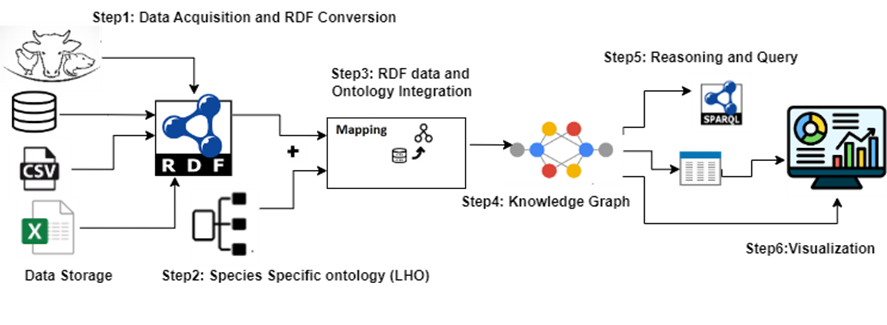

##### First we need to Install and import all necessary packages necessary classes inculding rdflib

In [26]:
! pip install pandas
! pip install openpyxl
! pip install rdflib
import pandas as pd
import rdflib
import hashlib
import numpy as np
import urllib.parse
from rdflib import Literal, Namespace, RDF, URIRef, Graph, RDFS, OWL
from rdflib.namespace import FOAF, XSD
from rdflib.plugins.sparql import prepareQuery

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


## Step1: Data Aquisiation and RDF convertion

##### For data aquisiation the code below loads data related to pigs, cattle, and poultry from CSV or Excel files into separate Pandas dataframes.

In [27]:
# Define the file paths
files = ['data/PigData/Lab4/PigLab4-1.csv',
         'data/CattleData/Cattle.xlsx',
         'data/PoultryData/Poultry.xlsx']

# Load the data into Pandas dataframes
dfs = []
for file in files:
    if file.endswith('.csv'):
        df = pd.read_csv(file)
    elif file.endswith('.xlsx'):
        df = pd.read_excel(file)
    else:
        print(f"Unsupported file format for {file}")
        continue
    dfs.append(df)

# Separate dataframes for each type of data
df = dfs[0]  # Assuming the first file is related to pigs
cattle_df = dfs[1]  # Assuming the second file is related to cattle
poultry_df = dfs[2]  # Assuming the third file is related to poultry

#To print the data frames, we can simply use the print() function: for example print(df)

##### For RDF conversion, the code initializes an RDFLib graph and binds namespaces for XML Schema, a custom ontology, SKOS, DECIDE, NCIT, and Agrovoc, providing context for representing data in RDF format, enabling interoperability and semantic understanding within the graph.

In [28]:
g = rdflib.Graph()
xsd = Namespace('http://www.w3.org/2001/XMLSchema#')
g.bind('xsd', xsd)

# Define your custom namespace for your ontology's properties
LHO = Namespace("http://www.purl.org/decide/LiveStockHealthOnto/LHO#")
g.bind('LHO', LHO)

SKOS = Namespace("http://www.w3.org/2004/02/skos/core#")
g.bind('skos', SKOS)

decide=  Namespace("http://www.purl.org/decide#")
g.bind('decide', decide)
ncit = Namespace("http://purl.obolibrary.org/obo/NCIT_C25464")
g.bind('ncit', ncit)
agrovoc = Namespace ("http://aims.fao.org/aos/agrovoc")
g.bind('agrovoc', agrovoc)



##### The code below iterates through a DataFrame , creates RDF triples for each row's data, and serializes the resulting graph into an RDF/XML file.

##### For Pig data frame RDf conversion

In [29]:
#For Pig Data frame RDF conversion
for index, row in df.iterrows():
    SampleNumber = row["SampleNumber"]
    Date = row["Date"]
    Pathogen = row["Pathogen"]
    Breed = row["Breed"]
    Country = row["Country"]
    Province = row["Province"]
    SampleType = row["SampleType"]
    SampleResult = row["Result"]
    DiagnosticTest = row["DiagnosticTest"]
    PigStage= row["PigStage"]

    
    # Create a unique URI for each sample based on the row index
    PigSample_uri = URIRef(f"http://www.purl.org/decide/LiveStockHealthOnto/LHO#Lab4PigSample_{index}")
    
    # Add sample type assertion
    g.add((PigSample_uri, RDF.type, LHO.PigSample))
    description = "An individual representing a sample from a Pig and Piglets."
    g.add((PigSample_uri, RDFS.comment, Literal(description, lang="en")))
    
    if "Pathogen" in row and row["Pathogen"]:
        Pathogen = row["Pathogen"]
        Pathogen_uri = URIRef(f"http://www.purl.org/decide/LiveStockHealthOnto/LHO#{Pathogen}")
        g.add((PigSample_uri, LHO.hasPathogen, Pathogen_uri))
        g.add((Pathogen_uri, RDF.type, decide.Pathogen))
        description = "An individual representing Pig pathogen."
        g.add((Pathogen_uri, RDFS.comment, Literal(description, lang="en")))
        
    if "Breed" in row and row["Breed"]:
        Breed = row["Breed"]
        Breed_uri = URIRef(f"http://www.purl.org/decide/LiveStockHealthOnto/LHO#{Breed}")
        g.add((PigSample_uri, LHO.hasBreed, Breed_uri))
        g.add((Breed_uri, RDF.type, LHO.Breed))
        description = "An individual representing a Piglet breed which is Meat."
        g.add((Breed_uri, RDFS.comment, Literal(description, lang="en")))
        
    if "DiagnosticTest" in row and row["DiagnosticTest"]:
        DiagnosticTest= row["DiagnosticTest"]
        DiagnosticTest_uri = URIRef(f"http://www.purl.org/decide/LiveStockHealthOnto/LHO#{DiagnosticTest}")
        g.add((PigSample_uri, LHO.hasDiagnosticTest, DiagnosticTest_uri))
        g.add((DiagnosticTest_uri, RDF.type, LHO.DiagnosticTest))
    if DiagnosticTest == "PCR":
        description = "An individual representing DNA/RNA amplification for rapid pathogen detection."
    elif SampleType == "Culture":
        description = "An individual representing a Growing live microorganisms for identification."
        g.add((DiagnosticTest_uri, RDFS.comment, Literal(description, lang="en")))
        
    if "Country" in row and row["Country"]:
        Country = row["Country"].strip()  # Use strip() to remove leading and trailing spaces
        # Encode the Country value to create a valid URI
        Country = urllib.parse.quote(Country)
        Country_uri = URIRef(f"http://www.purl.org/decide/LiveStockHealthOnto/LHO#{Country}")
    
        # Map to the specific class URI in your ontology and add the label
        g.add((PigSample_uri, LHO.hasCountry, Country_uri))
        g.add((Country_uri, RDF.type, URIRef("http://purl.obolibrary.org/obo/NCIT_C25464")))  # Use the specific class URI
        g.add((Country_uri, RDFS.label, Literal("Spain")))
        description = "An individual representing different Countries."
        g.add((Country_uri, RDFS.comment, Literal(description, lang="en")))
        
    if "Province" in row and row["Province"]:
        Province = row["Province"].strip()
        Province = urllib.parse.quote(Province)
        Province_uri = URIRef(f"http://www.purl.org/decide/LiveStockHealthOnto/LHO#{Province}")
        g.add((PigSample_uri, LHO.hasProvince, Province_uri))
        g.add((Province_uri, RDF.type, LHO.Province))
        description = "An individual representing different Province."
        g.add((Province_uri, RDFS.comment, Literal(description, lang="en")))
    
    if "PigStage" in row and row["PigStage"]:
        Stage = row["PigStage"]
        Stage_uri = URIRef(f"http://www.purl.org/decide/LiveStockHealthOnto/LHO#{Stage}")
        g.add((PigSample_uri, LHO.hasProductionStages, Stage_uri))
        g.add((Stage_uri, RDF.type, LHO.PigProductionStages))
        description = "An individual representing Production stage ."
        g.add((Stage_uri, RDFS.comment, Literal(description, lang="en")))
    
    if "SampleType" in row and row["SampleType"]:
        SampleType = row["SampleType"]
        SampleType_uri = URIRef(f"http://www.purl.org/decide/LiveStockHealthOnto/LHO#{SampleType}")
        # Add statements for SampleType
        g.add((PigSample_uri, LHO.hasSampleType, SampleType_uri))
        g.add((SampleType_uri, RDF.type, URIRef("http://www.purl.org/decide#SampleType")))
    if SampleType == "Autopsy":
        description = "An individual representing a cattle sample obtained through autopsy."
    elif SampleType == "BAL":
        description = "An individual representing a cattle sample obtained through bronchoalveolar lavage (BAL)."
    elif SampleType == "SWAB":
        description = "An individual representing a cattle sample obtained through swabbing."
    elif SampleType == "Missing":
        description = "An individual representing a missing or unspecified cattle sample type."
        g.add((SampleType_uri, RDFS.comment, Literal(description, lang="en")))
           
    if "Result" in row and row["Result"]:
        SampleResult = row["Result"]
        # Create a unique URI for the Result based on the value
        Result_uri = URIRef(f"http://www.purl.org/decide/LiveStockHealthOnto/LHO#{SampleResult}")
        g.add((PigSample_uri, LHO.hasResult, Result_uri))
        g.add((Result_uri, RDF.type, decide.SampleResult))
    if SampleResult == "1":
        description = "An individual representing a Positive test result"
    elif SampleResult == "0":
        description = "An individual representing a negative test result"
    elif SampleResult == "missing":
        description = "An individual representing an unknown or missing test result."
    g.add((Result_uri, RDFS.comment, Literal(description, lang="en")))


    if "Date" in row and not pd.isnull(row["Date"]):  # Check for NaN or None values
        Date = str(row["Date"]).strip()
    
    # Split the datetime string and take the date part
        Date = Date.split()[0]
    
    # Create a unique URI for the Date based on the value (use the Date directly)
        Date_uri = URIRef(f"http://www.purl.org/decide/LiveStockHealthOnto/LHO#{Date}")
    
    # Add Date assertion
        g.add((PigSample_uri, LHO.hasDate, Date_uri))
        g.add((Date_uri, RDF.type, LHO.Date))
    

# Serialize the RDF graph to a file
rdf_output_file = "outputPig.rdf"
g.serialize(rdf_output_file, format="xml")

# Serialize the RDF graph to Turtle format and print it too see RDF conversion
turtle_data = g.serialize(format="turtle")
print(turtle_data)

@prefix LHO: <http://www.purl.org/decide/LiveStockHealthOnto/LHO#> .
@prefix decide: <http://www.purl.org/decide#> .
@prefix ncit: <http://purl.obolibrary.org/obo/NCIT_C25464> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .

LHO:Lab4PigSample_0 a LHO:PigSample ;
    LHO:hasBreed LHO:Meat ;
    LHO:hasCountry LHO:Spain ;
    LHO:hasDate <http://www.purl.org/decide/LiveStockHealthOnto/LHO#01/07/2020> ;
    LHO:hasDiagnosticTest LHO:PCR ;
    LHO:hasPathogen LHO:Mycoplasmahyopneumoniae ;
    LHO:hasProductionStages LHO:Weaning ;
    LHO:hasProvince LHO:Valencia ;
    LHO:hasSampleType LHO:Tissue ;
    rdfs:comment "An individual representing a sample from a Pig and Piglets."@en .

LHO:Lab4PigSample_1 a LHO:PigSample ;
    LHO:hasBreed LHO:Meat ;
    LHO:hasCountry LHO:Spain ;
    LHO:hasDate <http://www.purl.org/decide/LiveStockHealthOnto/LHO#01/07/2020> ;
    LHO:hasDiagnosticTest LHO:PCR ;
    LHO:hasPathogen LHO:SwineInfluenzaVirus ;
    LHO:hasProductionStages LHO:Weaning ;


##### For Poultry Data frame RDF Conversion

In [30]:
#For Poultry Data Rdf conversion
#Add the necesary information in data frames
poultry_df['Country'] = 'TheNetherlands'
poultry_df['ProductionStages'] = 'Broiler'
poultry_df['Breed'] = 'Meat'
poultry_df['Result'] = '1'

for index, row in poultry_df.iterrows():
    Quarter = row['Quarter']
    IB = row['IB']
    AnimalType = row['AnimalType']
    Province = row['Province']
    
    # Create a unique URI for each sample based on the row index
    PoultrySample_uri = URIRef(f"http://www.purl.org/decide/LiveStockHealthOnto/LHO#Lab1PoultrySample_{index}")
     # Add sample type assertion
    g.add((PoultrySample_uri, RDF.type, LHO.PoultrySample))
    description = "An individual representing a sample from a Poultry or Chiken."
    g.add((PoultrySample_uri, RDFS.comment, Literal(description, lang="en")))

    if "Quarter" in row and row["Quarter"]:
        Date = row["Quarter"]
        Date_uri = URIRef(f"http://www.purl.org/decide/LiveStockHealthOnto/LHO#{Date}")
        g.add((PoultrySample_uri, LHO.hasDate, Date_uri))
        g.add((Date_uri, RDF.type, LHO.Date))
        description = "An individual representing a Particular Date."
        g.add((Date_uri, RDFS.comment, Literal(description, lang="en")))
    if "IB" in row and row["IB"]:
        Pathogen = row["IB"]
        Pathogen_uri = URIRef(f"http://www.purl.org/decide/LiveStockHealthOnto/LHO#{Pathogen}")
        g.add((PoultrySample_uri, LHO.hasPathogen, Pathogen_uri))
        g.add((Pathogen_uri, RDF.type, decide.Pathogen))
        description = "An individual representing Polutry Pathogen."
        g.add((Pathogen_uri, RDFS.comment, Literal(description, lang="en")))
    if "AnimalType" in row and row["AnimalType"]:
        SampleType = row["AnimalType"]
        SampleType_uri = URIRef(f"http://www.purl.org/decide/LiveStockHealthOnto/LHO#{SampleType}")
        g.add((PoultrySample_uri, LHO.hasSampleType, SampleType_uri))
        g.add((SampleType_uri, RDF.type, decide.SampleType))
        description = "An individual representing SampleType for Poultry."
        g.add((SampleType_uri, RDFS.comment, Literal(description, lang="en")))
    if "Province" in row and row["Province"]:
        Province = row["Province"]
        Province_uri = URIRef(f"http://www.purl.org/decide/LiveStockHealthOnto/LHO#{Province}")
        g.add((PoultrySample_uri, LHO.hasProvince, Province_uri))
        g.add((Province_uri, RDF.type, LHO.Province))
        description = "An individual representing different Province."
        g.add((Province_uri, RDFS.comment, Literal(description, lang="en")))
    if "Country" in row and row["Country"]:
        Country = row["Country"]
        Country_uri = URIRef(f"http://www.purl.org/decide/LiveStockHealthOnto/LHO#{Country}")
        g.add((PoultrySample_uri, LHO.hasCountry, Country_uri))
        g.add((Country_uri, RDF.type, URIRef("http://purl.obolibrary.org/obo/NCIT_C25464")))  # Use the specific class URI
        description = "An individual representing Country."
        g.add((Country_uri, RDFS.comment, Literal(description, lang="en")))
    if "ProductionStages" in row and row["ProductionStages"]:
        ProductionStage = row["ProductionStages"]
        ProductionStage_uri = URIRef(f"http://www.purl.org/decide/LiveStockHealthOnto/LHO#{ProductionStage}")
        g.add((PoultrySample_uri, LHO.hasProductionStages, ProductionStage_uri))
        g.add((ProductionStage_uri, RDF.type, LHO.PoultryProductionStages))
        description = "An individual representing Productionstages of Poultry Data."
        g.add((ProductionStage_uri, RDFS.comment, Literal(description, lang="en")))
    if "Breed" in row and row["Breed"]:
        Breed = row["Breed"]
        Breed_uri = URIRef(f"http://www.purl.org/decide/LiveStockHealthOnto/LHO#{Breed}")
        g.add((PoultrySample_uri, LHO.hasBreed, Breed_uri))
        g.add((Breed_uri, RDF.type, LHO.Breed))
        description = "An individual representing Breed Type."
        g.add((Breed_uri, RDFS.comment, Literal(description, lang="en")))
    if "Result" in row and row["Result"]:
        Result = row["Result"]
        Result_uri = URIRef(f"http://www.purl.org/decide/LiveStockHealthOnto/LHO#{Result}")
        g.add((PoultrySample_uri, LHO.hasResult, Result_uri))
        g.add((Result_uri, RDF.type, decide.SampleResult))
        description = "An individual representing pathogen result."
        g.add((Result_uri, RDFS.comment, Literal(description, lang="en")))
        
        # Serialize the RDF graph to a file
rdf_output_file = "output.rdf"
g.serialize(rdf_output_file, format="xml")

# Serialize the RDF graph to Turtle format and print it
turtle_data = g.serialize(format="turtle")
print(turtle_data)

@prefix LHO: <http://www.purl.org/decide/LiveStockHealthOnto/LHO#> .
@prefix decide: <http://www.purl.org/decide#> .
@prefix ncit: <http://purl.obolibrary.org/obo/NCIT_C25464> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .

LHO:Lab1PoultrySample_0 a LHO:PoultrySample ;
    LHO:hasBreed LHO:Meat ;
    LHO:hasCountry LHO:TheNetherlands ;
    LHO:hasDate LHO:2014-Q1 ;
    LHO:hasPathogen LHO:QX ;
    LHO:hasProductionStages LHO:Broiler ;
    LHO:hasProvince LHO:Noord-Brabant ;
    LHO:hasResult LHO:1 ;
    LHO:hasSampleType LHO:SS ;
    rdfs:comment "An individual representing a sample from a Poultry or Chiken."@en .

LHO:Lab1PoultrySample_1 a LHO:PoultrySample ;
    LHO:hasBreed LHO:Meat ;
    LHO:hasCountry LHO:TheNetherlands ;
    LHO:hasDate LHO:2014-Q1 ;
    LHO:hasPathogen LHO:793B ;
    LHO:hasProductionStages LHO:Broiler ;
    LHO:hasProvince LHO:Limburg ;
    LHO:hasResult LHO:1 ;
    LHO:hasSampleType LHO:SS ;
    rdfs:comment "An individual representing a sample from

##### For Cattle data frame RDF conversion

In [33]:
# Loop through rows in the "barometer_dt_Cattle" dataframe


for index, row in cattle_df.iterrows():
    PathogenCode = row["Pathogen"]
    Breed = row["Breed"]
    Country = row["Country"]
    Province = row["Province"]
    SampleType = row["SampleType"]
    Result = row["Result"]
    LabReference = row["LabReference"]
    DiagnosticTest = row["DiagnosticTest"]
    Date = row["Floored_date"]
    

    
    # Create a unique URI for each sample based on the row index
    CattleSample_uri = URIRef(f"http://www.purl.org/decide/LiveStockHealthOnto/LHO#Lab1CattleSample_{index}")
    
    # Add sample type assertion
    g.add((CattleSample_uri, RDF.type, LHO.CattleSample))
    description = "An individual representing a sample from a cattle."
    g.add((CattleSample_uri, RDFS.comment, Literal(description, lang="en")))
    
    if "Pathogen" in row and row["Pathogen"]:
        Pathogen = row["Pathogen"]
        Pathogen_uri = URIRef(f"http://www.purl.org/decide/LiveStockHealthOnto/LHO#{Pathogen}")
        g.add((CattleSample_uri, LHO.hasPathogen, Pathogen_uri))
        g.add((Pathogen_uri, RDF.type, decide.Pathogen))
        description = "An individual representing a cattle breed of mixed meat and dairy type."
        g.add((Pathogen_uri, RDFS.comment, Literal(description, lang="en")))
        
            
    if "Breed" in row and row["Breed"]:
        Breed = row["Breed"]
        Breed_uri = URIRef(f"http://www.purl.org/decide/LiveStockHealthOnto/LHO#{Breed}")
        g.add((CattleSample_uri, LHO.hasBreed, Breed_uri))
        g.add((Breed_uri, RDF.type, LHO.Breed))
        description = "An individual representing a cattle breed of mixed meat and dairy type."
        g.add((Breed_uri, RDFS.comment, Literal(description, lang="en")))
        
        
    if "DiagnosticTest" in row and row["DiagnosticTest"]:
        DiagnosticTest= row["DiagnosticTest"]
        DiagnosticTest_uri = URIRef(f"http://www.purl.org/decide/LiveStockHealthOnto/LHO#{DiagnosticTest}")
        g.add((CattleSample_uri, LHO.hasDiagnosticTest, DiagnosticTest_uri))
        g.add((DiagnosticTest_uri, RDF.type, LHO.DiagnosticTest))

    if "Country" in row and row["Country"]:
        Country = row["Country"].strip()  # Use strip() to remove leading and trailing spaces
        # Encode the Country value to create a valid URI
        encoded_country = urllib.parse.quote(Country)
        Country_uri = URIRef(f"http://www.purl.org/decide/LiveStockHealthOnto/LHO#{encoded_country}")
    
        # Map to the specific class URI in your ontology and add the label
        g.add((CattleSample_uri, LHO.hasCountry, Country_uri))
        g.add((Country_uri, RDF.type, URIRef("http://purl.obolibrary.org/obo/NCIT_C25464")))  # Use the specific class URI
        g.add((Country_uri, RDFS.label, Literal("The Netherland")))
        description = "An individual representing different Countries."
        g.add((Country_uri, RDFS.comment, Literal(description, lang="en")))

    
        
    if "Province" in row and row["Province"]:
        Province = row["Province"].strip()
        encoded_province = urllib.parse.quote(Province)
        Province_uri = URIRef(f"http://www.purl.org/decide/LiveStockHealthOnto/LHO#{encoded_province}")
        g.add((CattleSample_uri, LHO.hasProvince, Province_uri))
        g.add((Province_uri, RDF.type, LHO.Province))
        description = "An individual representing different Province."
        g.add((Province_uri, RDFS.comment, Literal(description, lang="en")))
    
    
    if "SampleType" in row and row["SampleType"]:
        SampleType = row["SampleType"]
        SampleType_uri = URIRef(f"http://www.purl.org/decide/LiveStockHealthOnto/LHO#{SampleType}")
        # Add statements for SampleType
        g.add((CattleSample_uri, LHO.hasSampleType, SampleType_uri))
        g.add((SampleType_uri, RDF.type, URIRef("http://www.purl.org/decide#SampleType")))
           
    if "Result" in row and row["Result"]:
        SampleResult = row["Result"]
    # Create a unique URI for the Result based on the value
        Result_uri = URIRef(f"http://www.purl.org/decide/LiveStockHealthOnto/LHO#{SampleResult}")
        g.add((CattleSample_uri, LHO.hasResult, Result_uri))
        g.add((Result_uri, RDF.type, decide.SampleResult))
        
    if "LabReference" in row and row["LabReference"]:
        LabReference = row["LabReference"]
    # Create a unique URI for the LabReference based on the value
        LabReference_uri = URIRef(f"http://www.purl.org/decide/LiveStockHealthOnto/LHO#{LabReference}")
        g.add((CattleSample_uri, LHO.hasLabReference, LabReference_uri))
        g.add((LabReference_uri, RDF.type, LHO.LabReference))

    if "Floored_date" in row and not pd.isnull(row["Floored_date"]):  # Check for NaN or None values
        Date = str(row["Floored_date"]).strip()
    
    # Split the datetime string and take the date part
        Date = Date.split()[0]
    
    # Create a unique URI for the Date based on the value (use the Date directly)
        Date_uri = URIRef(f"http://www.purl.org/decide/LiveStockHealthOnto/LHO#{Date}")
    
    # Add Date assertion
        g.add((CattleSample_uri, LHO.hasDate, Date_uri))
        g.add((Date_uri, RDF.type, LHO.Date))
    
    # Add any additional properties related to Date as needed


# Serialize the RDF graph to a file
rdf_output_file = "output.rdf"
g.serialize(rdf_output_file, format="xml")

#Serialize the RDF graph to Turtle format and print it
turtle_data = g.serialize(format="turtle")
print(turtle_data)

@prefix LHO: <http://www.purl.org/decide/LiveStockHealthOnto/LHO#> .
@prefix dc: <http://purl.org/dc/elements/1.1/> .
@prefix decide: <http://www.purl.org/decide#> .
@prefix decide1: <https://www.purl.org/decide#> .
@prefix ncit: <http://purl.obolibrary.org/obo/NCIT_C25464> .
@prefix obo: <http://purl.obolibrary.org/obo/> .
@prefix owl: <http://www.w3.org/2002/07/owl#> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix skos: <http://www.w3.org/2004/02/skos/core#> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

<http://aims.fao.org/aos/agrovoc/c_6145> a owl:Class ;
    rdfs:label "Poultry"@en ;
    obo:IAO_0000412 "https://agrovoc.fao.org/browse/agrovoc/en/page/c_6145" ;
    rdfs:comment "All domesticated birds used for the production of meat or eggs for consumption, for the production of other commercial products, for restocking, supplies of game, or for breeding these categories of birds." ;
    rdfs:sub

## Step2: Species Specific Ontology LHO 

##### LHO ontology is accesible on Bioportal at https://bioportal.bioontology.org/ontologies/LHO

## Step3: RDF Data and ontology integration

In [37]:

#Define the original path
#ontology_file = "Ontology/LivestockHealthOntology_updated.rdf"
#g.parse(ontology_file, format="xml")

g.serialize(destination='output/RDFoutputPig.owl', format="xml")


<Graph identifier=Nd41eeb7150a441dcb2aa3885e78cfb00 (<class 'rdflib.graph.Graph'>)>

### Query

In [36]:
query = """
PREFIX decide: <http://www.purl.org/decide#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX LHO: <http://www.purl.org/decide/LiveStockHealthOnto/LHO#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>

SELECT
  (strafter(str(?Sample), "#") AS ?SampleName)
  (strafter(str(?Pathogen), "#") AS ?PathogenName)
  (strafter(str(?Breed), "#") AS ?BreedName)
  (strafter(str(?LivestockProductionStages), "#") AS ?StagesName)
  (strafter(str(?SampleType), "#") AS ?SampleTypeName)
  (strafter(str(?DiagnosticTest), "#") AS ?DiagnosticTestName)
  (strafter(str(?Country), "#") AS ?CountryName)
  (strafter(str(?SampleResult), "#") AS ?SampleResultName)

WHERE {
  {
    ?Sample rdf:type LHO:PigSample .
    ?Sample LHO:hasPathogen ?Pathogen .
    ?Sample LHO:hasBreed ?Breed .
    ?Sample LHO:hasProductionStages ?LivestockProductionStages .
    ?Sample LHO:hasSampleType ?SampleType .
    ?Sample LHO:hasDiagnosticTest ?DiagnosticTest .
    ?Sample LHO:hasCountry ?Country .
    ?Sample LHO:hasResult ?SampleResult .
  }
  UNION
  {
    ?Sample rdf:type LHO:PoultrySample .
    ?Sample LHO:hasPathogen ?Pathogen .
    ?Sample LHO:hasSampleType ?SampleType .
    ?Sample LHO:hasCountry ?Country .
    ?Sample LHO:hasProductionStages ?LivestockProductionStages .
    ?Sample LHO:hasBreed ?Breed .
    ?Sample LHO:hasResult ?SampleResult .
  }
  UNION
  {
    ?Sample rdf:type LHO:CattleSample .
    ?Sample LHO:hasPathogen ?Pathogen .
    ?Sample LHO:hasSampleType ?SampleType .
    ?Sample LHO:hasCountry ?Country .
    ?Sample LHO:hasBreed ?Breed .
    ?Sample LHO:hasResult ?SampleResult .
    ?Sample LHO:hasDiagnosticTest ?DiagnosticTest .
  }
}
"""
# Execute the query and retrieve the results
results = g.query(query)

# Convert the results to a Pandas dataframe
data = []
for row in results:
    data.append(list(row))
df = pd.DataFrame(data, columns=["Sample", "Pathogen", "Breed","ProductionStages", "SampleType",  "DiagnosticTest", "Country", "SampleResult"])

# Display the dataframe
df

,Sample,Pathogen,Breed,ProductionStages,SampleType,DiagnosticTest,Country,SampleResult
0,Lab4PigSample_1,SwineInfluenzaVirus,Meat,Weaning,Tissue,PCR,Spain,1
1,Lab4PigSample_2,Mycoplasmahyopneumoniae,Meat,Weaning,Tissue,PCR,Spain,1
2,Lab4PigSample_3,SwineInfluenzaVirus,Meat,Finishing,Tissue,PCR,Spain,1
3,Lab1PoultrySample_0,QX,Meat,Broiler,SS,None,TheNetherlands,1
4,Lab1PoultrySample_1,793B,Meat,Broiler,SS,None,TheNetherlands,1
5,Lab1PoultrySample_2,Mass,Meat,Broiler,SS,None,TheNetherlands,1
6,Lab1PoultrySample_3,QX,Meat,Broiler,SS,None,TheNetherlands,1
7,Lab1CattleSample_0,PM,Meat,None,Autopsy,PCR,TheNetherlands,1
8,Lab1CattleSample_1,BRSV,Dairy,None,BAL,Culture,TheNetherlands,1
